Connected to eva (Python 3.13.1)

Jack patients:  1222 --> 97
97
EVA patients:  723 --> 72
71
EVA controls:  104 --> 12
12


<ipython-input-1-2c37af28b4dc>:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['Sex_bin'] = cluster_df['SEX'].map(map_)


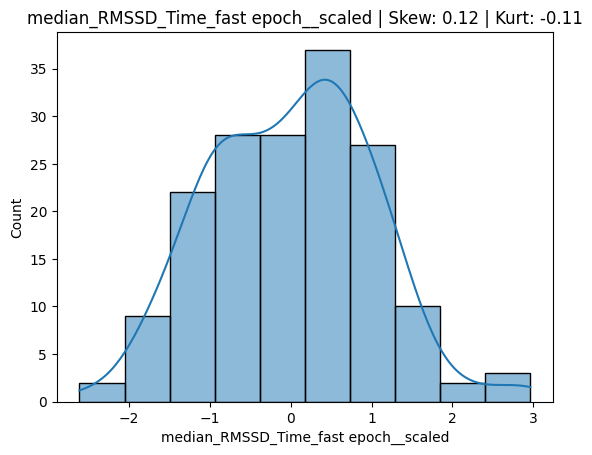

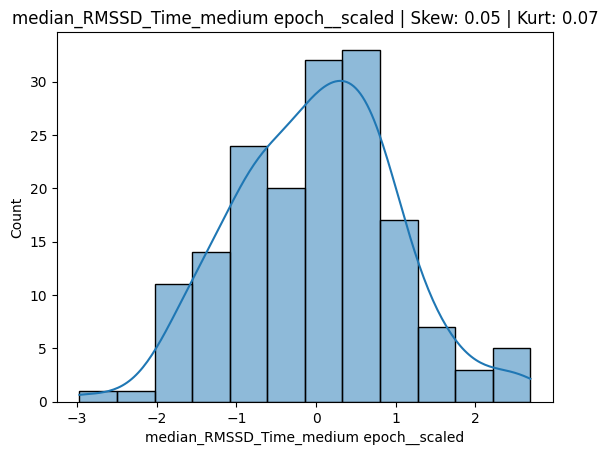

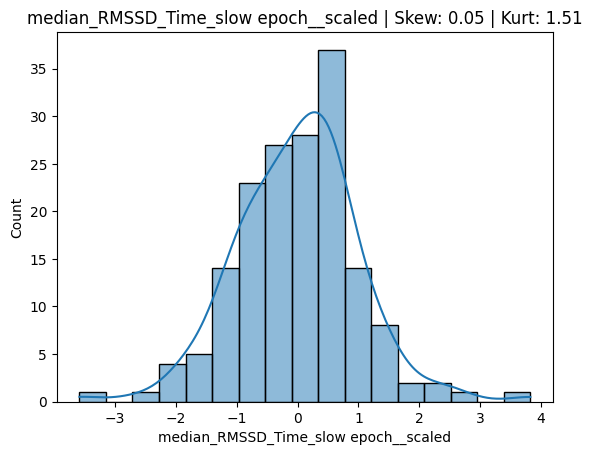

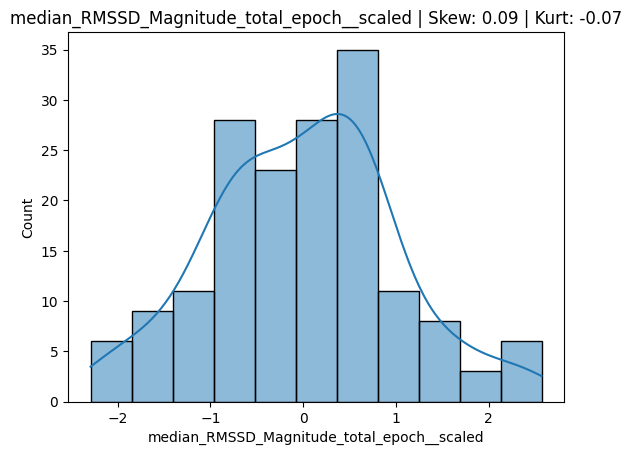

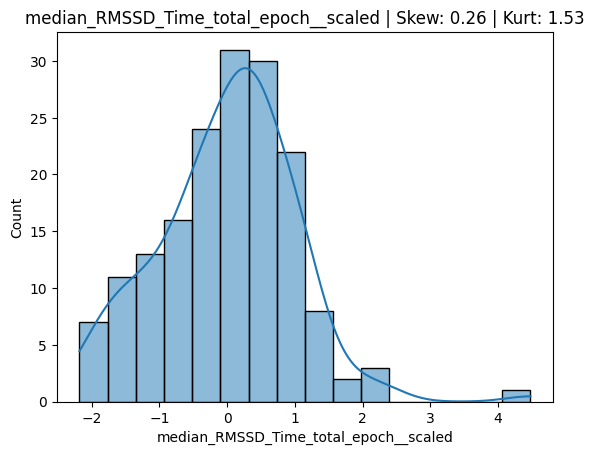

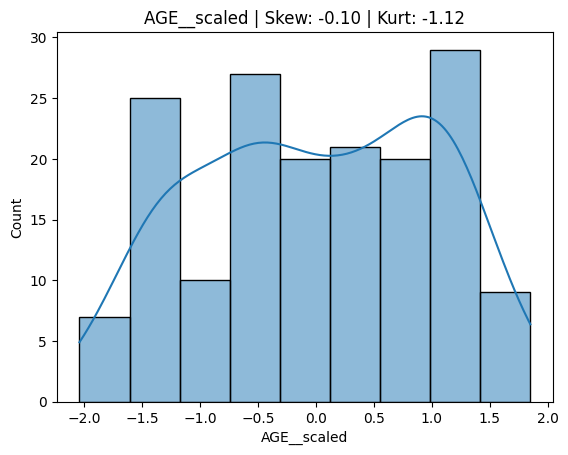

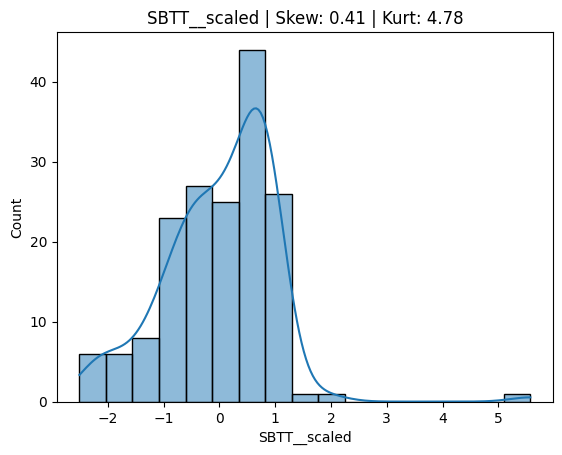

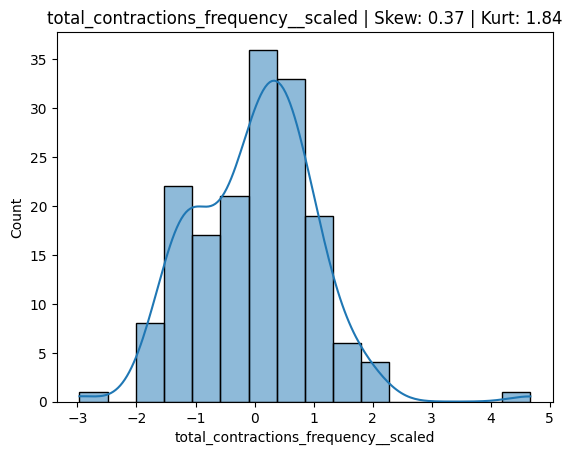

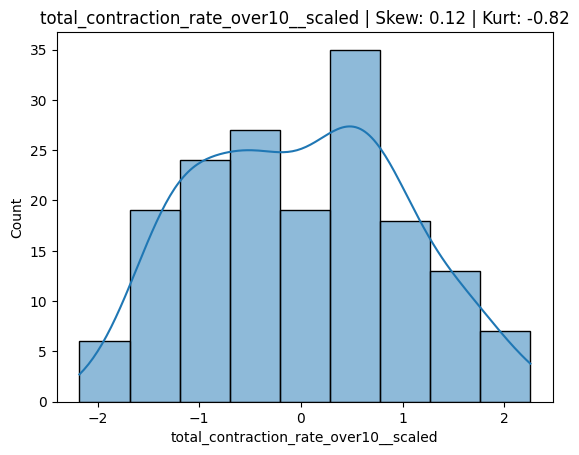

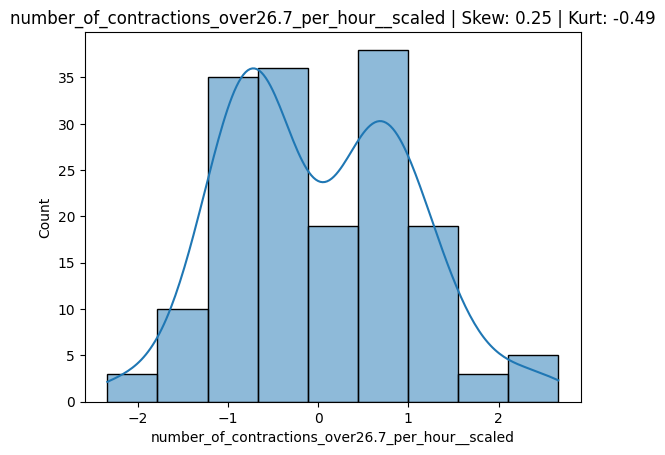

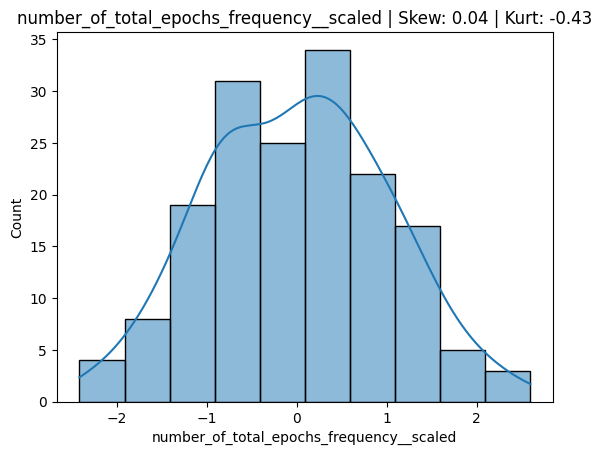

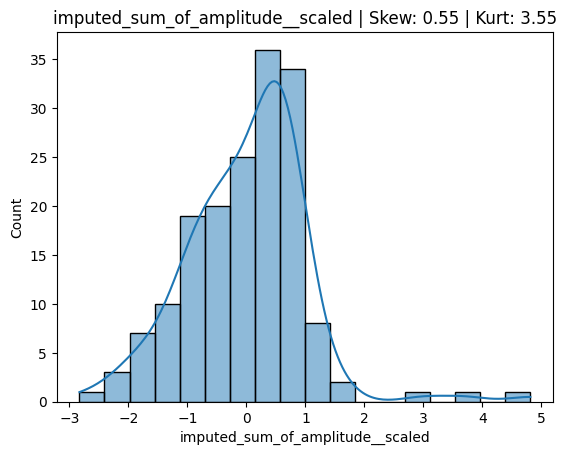

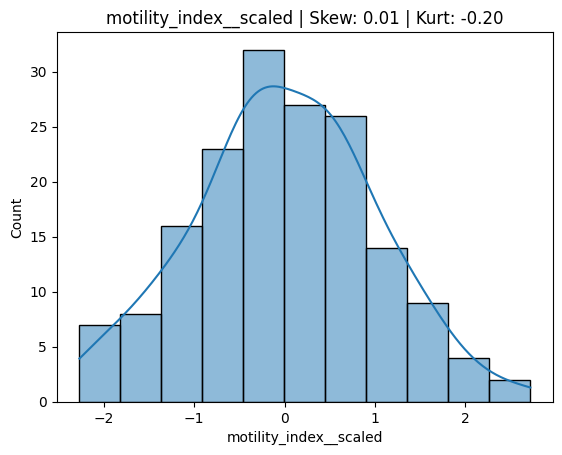

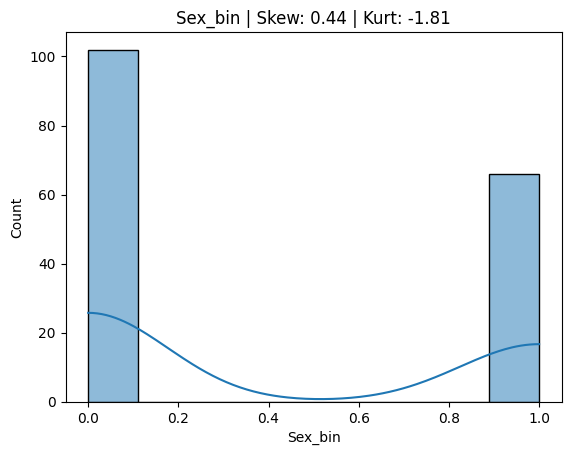

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcdefaults()
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression


def load_and_prepare_control_data(epoch_cols, rmssd_cols, clin_cols):
    demo_control_df = pd.read_excel('input_data/Copy of Demographic info_historical controls.xlsx')
    demo_control_df['combined_ID'] = demo_control_df['SITEN'].astype(str) + demo_control_df['SUBJID'].astype(str)
    demo_control_df['combined_ID'] = demo_control_df['combined_ID'].astype(str)

    rmssd_control_df = pd.read_csv('input_data/Final_Control_Patients_5min_RMSSD.csv')
    rmssd_control_df['combined_ID'] = rmssd_control_df['combined_ID'].astype(str)

    epoch_control_df = pd.read_csv('input_data/Final_Control_Patients_5min.csv')
    epoch_control_df['combined_ID'] = epoch_control_df['combined_ID'].astype(str)
    epoch_control_filtered_df = epoch_control_df[['combined_ID'] + epoch_cols].drop_duplicates()
    print('Jack patients: ', len(epoch_control_df), '-->', len(epoch_control_filtered_df))

    demo_control_df_joined = demo_control_df.merge(rmssd_control_df, on='combined_ID')
    demo_control_df_joined_filtered = demo_control_df_joined[rmssd_cols + ['combined_ID', 'SEXTEXT', 'AGE'] + clin_cols]
    control_cluster_df = demo_control_df_joined_filtered.merge(epoch_control_filtered_df, on='combined_ID')
    print(len(control_cluster_df))
    return control_cluster_df

def load_and_prepare_eva_data(epoch_cols, rmssd_cols):
    rmssd_eva_df = pd.read_csv('input_data/Final_EVA_Patients_5min_RMSSD_joined.csv')
    epoch_eva_df = pd.read_csv('input_data/Final_EVA_Patients_5min.csv')
    rmssd_eva_df['combined_ID'] = rmssd_eva_df['combined_ID'].astype(str)
    epoch_eva_df['combined_ID'] = epoch_eva_df['combined_ID'].astype(str)
    epoch_eva_filtered_df = epoch_eva_df[['combined_ID'] + epoch_cols].drop_duplicates()
    print('EVA patients: ', len(epoch_eva_df), '-->', len(epoch_eva_filtered_df))
    rmssd_eva_filtered_df = rmssd_eva_df[['combined_ID', 'SBTT...34', 'Age', 'Sex', 'groups'] + rmssd_cols]
    eva_cluster_df = rmssd_eva_filtered_df.merge(epoch_eva_filtered_df, on='combined_ID')
    print(len(eva_cluster_df))
    return eva_cluster_df

def load_and_prepare_eva_control_data(epoch_cols, rmssd_cols):
    rmssd_eva_control_df = pd.read_csv('input_data/Final_EVA_Controls_5min_joined.csv')
    epoch_eva_control_df = pd.read_csv('input_data/Final_EVA_Controls_5min.csv')
    rmssd_eva_control_df['combined_ID'] = rmssd_eva_control_df['combined_ID'].astype(str)
    epoch_eva_control_df['combined_ID'] = epoch_eva_control_df['combined_ID'].astype(str)
    epoch_eva_control_filtered_df = epoch_eva_control_df[['combined_ID'] + epoch_cols].drop_duplicates()
    print('EVA controls: ', len(epoch_eva_control_df), '-->', len(epoch_eva_control_filtered_df))
    rmssd_eva_control_filtered_df = rmssd_eva_control_df[['combined_ID', 'SBTT', 'AGE', 'SEX'] + rmssd_cols]
    eva_control_cluster_df = rmssd_eva_control_filtered_df.merge(epoch_eva_control_filtered_df, on='combined_ID')
    print(len(eva_control_cluster_df))
    return eva_control_cluster_df


def rename_columns(df, rename_map):
    columns_to_rename = {k: v for k, v in rename_map.items() if k in df.columns}
    return df.rename(columns=columns_to_rename)


def residualize(df, features, confounders):
    """
    Residualize selected features on confounders.
    
    Parameters
    ----------
    df : DataFrame
        Input data.
    features : list of str
        GI features to residualize.
    confounders : list of str
        Columns to adjust for (e.g., age, sex, cohort).
        
    Returns
    -------
    DataFrame with residualized features (same shape as input).
    """
    # One-hot encode categorical confounders
    X_conf = pd.get_dummies(df[confounders], drop_first=True)
    
    residualized = df.copy()
    
    for f in features:
        y = df[f].values
        model = LinearRegression().fit(X_conf, y)
        y_pred = model.predict(X_conf)
        residuals = y - y_pred
        residualized[f] = residuals
    return residualized


def impute_missing_values(df, numerical_cols):
    # Impute missing sex with mode
    df['Sex_bin'] = SimpleImputer(strategy="most_frequent").fit_transform(df[['Sex_bin']])
    # Impute continuous variables
    imputer = IterativeImputer(
        estimator=ExtraTreesRegressor(n_estimators=200, random_state=0, n_jobs=-1),
        initial_strategy="median",
        max_iter=20,
        sample_posterior=False, 
        random_state=0
    )
    X_for_impute = df[numerical_cols + ['Sex_bin']]
    X_imp = imputer.fit_transform(X_for_impute)
    imp_df = pd.DataFrame(X_imp, columns=numerical_cols + ['Sex_bin'], index=df.index)
    df[numerical_cols] = imp_df[numerical_cols]
    df['Sex_bin'] = imp_df['Sex_bin']
    return df


def transform_features(df, numerical_cols):
    pt = PowerTransformer(method='yeo-johnson')
    num_transformed = pt.fit_transform(df[numerical_cols])
    scaler = StandardScaler()
    num_scaled = scaler.fit_transform(num_transformed)
    sex = df[['Sex_bin']].astype(float).to_numpy()
    Z = np.hstack([num_scaled, sex])
    z_cols = [f"{c}__scaled" for c in numerical_cols] + ['Sex_bin']
    Z_df = pd.DataFrame(Z, columns=z_cols, index=df.index)
    return Z_df


def map_cohort(row):
    source = str(row.get('source', '')).lower()
    sbtt = row.get('SBTT', None)
    group = row.get('groups', None)

    if source == 'jack':
        return 'normal'
    elif source == 'eva_control':
        return 'eva_control'
    elif source == 'eva_pat':
        if pd.notna(sbtt) and sbtt <= 360:
            return group if pd.notna(group) and str(group).strip() != '' else 'unknown'
        elif pd.notna(sbtt) and sbtt > 360:
            return 'prolonged_SBTT'
        else:
            return 'unknown'
    else:
        return 'unknown'


if __name__ == "__main__":
    rmssd_cols = ['median_RMSSD_Time_fast epoch', 'median_RMSSD_Time_medium epoch', 'median_RMSSD_Time_slow epoch', 'median_RMSSD_Magnitude_total_epoch', 'median_RMSSD_Time_total_epoch']
    epoch_cols = ['total_contractions_frequency', 'total_contraction_rate_over10', 'number_of_contractions_over26.7_per_hour', 'number_of_total_epochs_frequency', 'imputed_sum_of_amplitude', 'motility_index']
    clin_cols = ['SBTT']
    rename_map = {
            'Age': 'AGE',
            'Sex': 'SEX',
            'SEXTEXT': 'SEX',
            'SBTT...34': 'SBTT'
        }

    control_cluster_df = load_and_prepare_control_data(epoch_cols, rmssd_cols, clin_cols)
    eva_cluster_df = load_and_prepare_eva_data(epoch_cols, rmssd_cols)
    eva_control_cluster_df = load_and_prepare_eva_control_data(epoch_cols, rmssd_cols)

    control_cluster_df = rename_columns(control_cluster_df, rename_map)
    eva_cluster_df = rename_columns(eva_cluster_df, rename_map)
    eva_control_cluster_df = rename_columns(eva_control_cluster_df, rename_map)

    control_cluster_df['source'] = 'jack'
    eva_cluster_df['source'] = 'eva_pat'
    eva_control_cluster_df['source'] = 'eva_control'

    cluster_w_eva_control_df = pd.concat([control_cluster_df, eva_cluster_df, eva_control_cluster_df])
    cluster_w_eva_control_df[["AGE", "SBTT"]] = cluster_w_eva_control_df[["AGE", "SBTT"]].apply(pd.to_numeric, errors="coerce")
    cluster_w_eva_control_df['cohort'] = cluster_w_eva_control_df.apply(map_cohort, axis=1)
    cluster_w_eva_control_df.drop(columns=['groups'], inplace=True)
    cluster_df = cluster_w_eva_control_df[cluster_w_eva_control_df['cohort'] != 'eva_control']

    map_ = {'Female': 1, 'Male': 0}
    cluster_df['Sex_bin'] = cluster_df['SEX'].map(map_)

    numerical_cols = ['median_RMSSD_Time_fast epoch', 'median_RMSSD_Time_medium epoch', 'median_RMSSD_Time_slow epoch', 'median_RMSSD_Magnitude_total_epoch','median_RMSSD_Time_total_epoch', 'AGE', 'SBTT', 'total_contractions_frequency', 'total_contraction_rate_over10', 'number_of_contractions_over26.7_per_hour', 'number_of_total_epochs_frequency', 'imputed_sum_of_amplitude', 'motility_index']
    meta_cols = ['combined_ID', 'source', 'cohort']
    categorical_cols = ['SEX', 'Sex_bin']
    GI_cols = ['median_RMSSD_Time_fast epoch', 'median_RMSSD_Time_medium epoch', 'median_RMSSD_Time_slow epoch', 'median_RMSSD_Magnitude_total_epoch','median_RMSSD_Time_total_epoch', 'SBTT', 'total_contractions_frequency', 'total_contraction_rate_over10', 'number_of_contractions_over26.7_per_hour', 'number_of_total_epochs_frequency', 'imputed_sum_of_amplitude', 'motility_index']

    cluster_df_imputed = impute_missing_values(cluster_df.copy(), numerical_cols)
    cluster_df_residualized = residualize(cluster_df_imputed, features=GI_cols, confounders=['AGE', 'SEX'])
    Z_df_imputed = transform_features(cluster_df_residualized, numerical_cols)
    
    Z_df_imputed.to_excel('output_data/transformed_residualized_features_imputed.xlsx', index=False)
    for col in Z_df_imputed.columns:
        sns.histplot(Z_df_imputed[col], kde=True)
        plt.title(f"{col} | Skew: {skew(Z_df_imputed[col]):.2f} | Kurt: {kurtosis(Z_df_imputed[col]):.2f}")
        plt.show()

    non_imputed_cluster_df = cluster_df.copy().dropna()
    Z_df_unimputed = transform_features(non_imputed_cluster_df, numerical_cols)
    Z_df_unimputed.to_excel('output_data/transformed_features_unimputed.xlsx', index=False)

In [ ]:
def check_correlation(df_raw, df_resid, features, confounder='age'):
    results = []
    for f in features:
        r_before = df_raw[f].corr(df_raw[confounder])
        r_after  = df_resid[f].corr(df_raw[confounder])
        results.append((f, r_before, r_after))
    return pd.DataFrame(results, columns=['Feature','Corr_before','Corr_after'])

In [ ]:
check_correlation(cluster_df_imputed, cluster_df_residualized, GI_cols, 'AGE')

,Feature,Corr_before,Corr_after
0,median_RMSSD_Time_fast epoch,-0.107694,-7.360221e-17
1,median_RMSSD_Time_medium epoch,0.124771,4.151010e-17
2,median_RMSSD_Time_slow epoch,-0.001014,0.000000e+00
3,median_RMSSD_Magnitude_total_epoch,0.245146,2.846809e-16
4,median_RMSSD_Time_total_epoch,-0.004999,-1.030853e-16
5,SBTT,-0.025142,-1.560122e-17
6,total_contractions_frequency,0.145351,3.494687e-17
7,total_contraction_rate_over10,0.090910,5.746797e-17
8,number_of_contractions_over26.7_per_hour,0.192564,1.124906e-16
9,number_of_total_epochs_frequency,0.170861,3.311834e-17


In [ ]:
check_correlation(cluster_df_imputed, cluster_df_residualized, GI_cols, 'Sex_bin')

,Feature,Corr_before,Corr_after
0,median_RMSSD_Time_fast epoch,-0.070117,-5.467122e-17
1,median_RMSSD_Time_medium epoch,-0.113361,-3.766979e-17
2,median_RMSSD_Time_slow epoch,-0.057299,-6.846190e-17
3,median_RMSSD_Magnitude_total_epoch,-0.039116,-8.198105e-17
4,median_RMSSD_Time_total_epoch,-0.106307,-8.330263e-17
5,SBTT,-0.078690,-3.649586e-17
6,total_contractions_frequency,-0.056254,-3.594226e-17
7,total_contraction_rate_over10,-0.128933,1.266532e-17
8,number_of_contractions_over26.7_per_hour,0.047507,6.652446e-17
9,number_of_total_epochs_frequency,0.104529,-3.122318e-17
